# IMPORT PACKAGE

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan

# IMPORT DATA

In [2]:
# Coba baca berkas dengan pengkodean yang berbeda, seperti 'latin-1'
df = pd.read_csv('Jumlah Keberangkatan Penumpang Pelabuhan Tanjung Perak.csv', encoding='latin-1')
df['Bulan'] = pd.to_datetime(df['Bulan'])
df.set_index('Bulan', inplace=True)

# Tampilkan DataFrame
print(df)

            Jumlah Keberangkatan Penumpang  DummyBulanIdulFitri  \
Bulan                                                             
2014-01-01                         22103.0                  0.0   
2014-02-01                         23436.0                  0.0   
2014-03-01                         25760.0                  0.0   
2014-04-01                         17508.0                  0.0   
2014-05-01                         19552.0                  0.0   
...                                    ...                  ...   
2023-08-01                         74782.0                  0.0   
2023-09-01                         63942.0                  0.0   
2023-10-01                         68093.0                  0.0   
2023-11-01                         53545.0                  0.0   
2023-12-01                         46329.0                  0.0   

           DummyIdulFitri DummyIdulAdha  DummyBulanIdulAdha  
Bulan                                                        
2014

# MEMBAGI DATA

In [3]:
# Membagi data menjadi insample (96 data pertama) dan outsample (12 data terakhir)
insample = df[:96]   # 96 data pertama
outsample = df[96:]  # 12 data terakhir

# VARIABEL DEPENDEN DAN INDEPENDEN

In [4]:
# Definisikan variabel dependen (y) dan variabel independen (X) untuk insample
y_insample = insample['Jumlah Keberangkatan Penumpang']
X_insample = insample[['DummyBulanIdulFitri', 'DummyIdulFitri', 'DummyBulanIdulAdha', 'DummyIdulAdha']]

In [5]:
# Definisikan variabel dependen (y) dan variabel independen (X) untuk insample
y_outsample = outsample['Jumlah Keberangkatan Penumpang']
X_outsample = outsample[['DummyBulanIdulFitri', 'DummyIdulFitri', 'DummyBulanIdulAdha', 'DummyIdulAdha']]

# MENAMBAHKAN KONSTANTA

In [6]:
# Menambahkan konstanta ke dalam model regresi
X_insample = sm.add_constant(X_insample)
X_outsample = sm.add_constant(X_outsample)

# Stasioneritas

## Dalam Mean

### Level

In [8]:
!pip install statsmodels
import statsmodels.tsa.stattools as ts

def test_stationarity(timeseries):
    # Use ts.adfuller since the function is imported from statsmodels.tsa.stattools
    result = ts.adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Stasioner")
    else:
        print("Tidak Stasioner")

print("Uji Stasioneritas data asli (In-sample):")
test_stationarity(y_insample)

Uji Stasioneritas data asli (In-sample):
ADF Statistic: -2.094931883155056
p-value: 0.24655739429290313
Critical Values: {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}
Tidak Stasioner


### Differencing 1

In [9]:
insample['diff'] = y_insample.diff().dropna()

print("\nUji Stasioneritas setelah differencing (In-sample):")
test_stationarity(insample['diff'].dropna())


Uji Stasioneritas setelah differencing (In-sample):
ADF Statistic: -4.069553791077843
p-value: 0.0010870488298301143
Critical Values: {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}
Stasioner


<ipython-input-9-9c07b7f3db3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = y_insample.diff().dropna()


## Varians

In [10]:
from statsmodels.tsa.stattools import kpss

# Asumsikan 'data' adalah data deret waktu Anda
result = kpss(y_insample, regression='c')

print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

if result[1] > 0.05:
    print("Stasioner dalam varians")
else:
    print("Tidak stasioner dalam varians")

KPSS Statistic: 0.08051183870074664
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stasioner dalam varians


<ipython-input-10-a361914483f3>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(y_insample, regression='c')


# ESTIMASI PARAMETER

## Idul Adha dan Idul Fitri

In [11]:
# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample).fit()

# Melihat ringkasan hasil model insample
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     6.741
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           8.49e-05
Time:                        04:48:51   Log-Likelihood:                -1086.7
No. Observations:                  96   AIC:                             2183.
Df Residuals:                      91   BIC:                             2196.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -30.3375   2

<ipython-input-11-56d23b90a9b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0


## Idul Fitri

### Variabel Dummy Gabungan Idul Fitri dan Bulan Idul Fitri

In [12]:
# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample[['DummyBulanIdulFitri', 'DummyIdulFitri']]).fit()

# Melihat ringkasan hasil model insample
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.133
Model:                            OLS   Adj. R-squared (uncentered):              0.115
Method:                 Least Squares   F-statistic:                              7.233
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                     0.00120
Time:                        04:49:39   Log-Likelihood:                         -1092.3
No. Observations:                  96   AIC:                                      2189.
Df Residuals:                      94   BIC:                                      2194.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

<ipython-input-12-d780743aad99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0


### Variabel Dummy Bulan Idul Fitri

In [13]:
# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample[['DummyBulanIdulFitri']]).fit()

# Melihat ringkasan hasil model insample
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.102
Model:                            OLS   Adj. R-squared (uncentered):              0.093
Method:                 Least Squares   F-statistic:                              10.83
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                     0.00140
Time:                        04:50:19   Log-Likelihood:                         -1094.0
No. Observations:                  96   AIC:                                      2190.
Df Residuals:                      95   BIC:                                      2192.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

<ipython-input-13-24e640e64586>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0


### Variabel Dummy Idul Fitri

In [14]:
# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample[[ 'DummyIdulFitri']]).fit()

# Melihat ringkasan hasil model insample
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.133
Model:                            OLS   Adj. R-squared (uncentered):              0.124
Method:                 Least Squares   F-statistic:                              14.61
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                    0.000236
Time:                        04:51:37   Log-Likelihood:                         -1092.3
No. Observations:                  96   AIC:                                      2187.
Df Residuals:                      95   BIC:                                      2189.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

<ipython-input-14-9294fc7055e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0


## Idul Adha

### Variabel Dummy Gabungan Idul Adha dab Bulan Idul Adha

In [15]:
# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample[['DummyBulanIdulAdha', 'DummyIdulAdha']]).fit()

# Melihat ringkasan hasil model insample
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.076
Method:                 Least Squares   F-statistic:                              4.946
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                     0.00907
Time:                        04:52:27   Log-Likelihood:                         -1094.3
No. Observations:                  96   AIC:                                      2193.
Df Residuals:                      94   BIC:                                      2198.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

<ipython-input-15-59be0f399344>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0


In [16]:
# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff']= pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample[['DummyBulanIdulAdha']]).fit()

# Melihat ringkasan hasil model insample
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.091
Model:                            OLS   Adj. R-squared (uncentered):              0.082
Method:                 Least Squares   F-statistic:                              9.538
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                     0.00264
Time:                        04:53:11   Log-Likelihood:                         -1094.5
No. Observations:                  96   AIC:                                      2191.
Df Residuals:                      95   BIC:                                      2194.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

<ipython-input-16-edc785063729>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff']= pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0


In [17]:
# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample[[ 'DummyIdulAdha']]).fit()

# Melihat ringkasan hasil model insample
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.086
Model:                            OLS   Adj. R-squared (uncentered):              0.076
Method:                 Least Squares   F-statistic:                              8.929
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                     0.00357
Time:                        04:54:04   Log-Likelihood:                         -1094.8
No. Observations:                  96   AIC:                                      2192.
Df Residuals:                      95   BIC:                                      2194.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

<ipython-input-17-4c617c7d4d4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0


Pemilihan model berdasarkan p-value kurang dari taraf signifikansi dalam hal ini taraf signifikansinya adalah 5 % dan juga yang mempunyai nilai AIC terkecil.
Model terbaik yang terpilih adalah model regresi dummy idul fitri sehingga dapat dilanjutkan ke proses uji diagnostik model.

# Uji Diagnostik Model

<ipython-input-18-de6e736f0f1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0


Uji Breusch-Pagan:
  Statistik: 3.3825
  p-value: 0.4960
  Tidak ada indikasi heteroskedastisitas
Uji Durbin-Watson: 2.4592
  Tidak ada indikasi autokorelasi


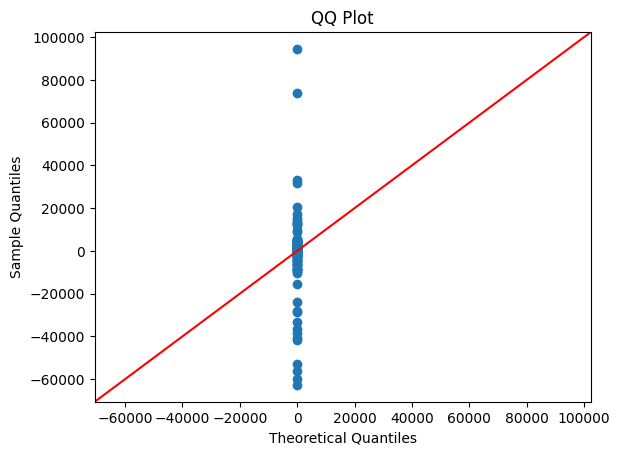

In [18]:
# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample[['DummyIdulFitri']]).fit()

# Mengambil residual dari model
residuals = model.resid

# Uji Heteroskedastisitas menggunakan Uji Breusch-Pagan
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X_insample)
print('Uji Breusch-Pagan:')
print(f'  Statistik: {bp_test[0]:.4f}')
print(f'  p-value: {bp_test[1]:.4f}')

# Evaluasi hasil uji heteroskedastisitas
if bp_test[1] < 0.05:
  print('  Indikasi heteroskedastisitas')
else:
  print('  Tidak ada indikasi heteroskedastisitas')

# Uji Autokorelasi Residual menggunakan Uji Durbin-Watson
dw_test = sm.stats.durbin_watson(residuals)
print(f'Uji Durbin-Watson: {dw_test:.4f}')

# Evaluasi hasil uji autokorelasi
if dw_test < 1.5:
    print('  Indikasi autokorelasi positif')
elif dw_test > 2.5:
    print('  Indikasi autokorelasi negatif')
else:
    print('  Tidak ada indikasi autokorelasi')

# Visualisasi Normalitas dengan QQ plot
sm.qqplot(residuals, line='45')
plt.title('QQ Plot')
plt.show()
# Keputusan QQ Plot: Periksa apakah titik-titik berada di sepanjang garis 45 derajat. Jika tidak, ini menunjukkan deviasi dari normalitas.

# Evaluasi Akurasi Model

In [19]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Convert relevant columns in X_insample and insample['diff'] to numeric types
X_insample = X_insample.apply(pd.to_numeric, errors='coerce').fillna(0) # Fill NaN values with 0
insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0

# Create the model
model = sm.OLS(insample['diff'], X_insample[['DummyIdulFitri']]).fit()

# Prediksi untuk data insample
# Use the same features for prediction as used for training the model
y_pred_insample = model.predict(X_insample[['DummyIdulFitri']])

# Evaluasi model untuk insample
mae = mean_absolute_error(insample['diff'], y_pred_insample)
mse = mean_squared_error(insample['diff'], y_pred_insample)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(insample['diff'], y_pred_insample)

print('Evaluasi Model (Insample):')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2%}')

# Definisikan variabel dependen (y) dan tambahkan variabel dummy Idul Fitri dan Time untuk outsample
y_outsample = outsample['Jumlah Keberangkatan Penumpang']
# Ensure the same features are used here as well.
X_outsample = outsample[['DummyIdulFitri']]

# Convert relevant columns to numeric types and handle NaN
X_outsample = X_outsample.apply(pd.to_numeric, errors='coerce').fillna(0)
y_outsample = pd.to_numeric(y_outsample, errors='coerce').fillna(0)

# Menambahkan konstanta ke dalam model regresi
# X_outsample = sm.add_constant(X_outsample)
# You may not need to add a constant if your model was not trained with one.

# Prediksi untuk data outsample
y_pred_outsample = model.predict(X_outsample)

# Evaluasi model untuk outsample
mae_outsample = mean_absolute_error(y_outsample, y_pred_outsample)
mse_outsample = mean_squared_error(y_outsample, y_pred_outsample)
rmse_outsample = np.sqrt(mse_outsample)
mape_outsample = mean_absolute_percentage_error(y_outsample, y_pred_outsample)

print('Evaluasi Model (Outsample):')
print(f'MAE: {mae_outsample:.2f}')
print(f'MSE: {mse_outsample:.2f}')
print(f'RMSE: {rmse_outsample:.2f}')
print(f'MAPE: {mape_outsample:.2%}')

Evaluasi Model (Insample):
MAE: 11643.05
MSE: 446857847.87
RMSE: 21139.01
MAPE: 107.14%
Evaluasi Model (Outsample):
MAE: 51591.33
MSE: 3266099147.16
RMSE: 57149.80
MAPE: 92.37%


<ipython-input-19-a9da1631cd74>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insample['diff'] = pd.to_numeric(insample['diff'], errors='coerce').fillna(0) # Fill NaN values with 0
